<a href="https://colab.research.google.com/github/andrewp2303/day_night_generalizability/blob/main/daynight_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description and Motivation
This project intends to experiment with how modern CNN architectures can benefit from certain pre-training transformations when only given access to daytime training data but hoping to generalize to nighttime data.

The motivation here is that for researchers working with extremely complex data, recreating nighttime images from daytime images may be too intensive to be feasible. Thus, finding simple, recognizable transformations that make a big difference in generalizability can be very useful.

## Imports

In [1]:
# all necessary imports
from __future__ import print_function, division
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import time, os, copy
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random, PIL, math
from PIL import Image
from termcolor import colored

cudnn.benchmark = True

## Model Training/Testing

In [2]:
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# trains the model on a train/validation set and returns it
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_loss, train_loss, val_acc, train_acc = [], [], [], []
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='val': val_loss.append(epoch_loss)
            if phase=='train': train_loss.append(epoch_loss)

            if phase=='val': val_acc.append(epoch_acc)
            if phase=='train': train_acc.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Average epoch time: {(time_elapsed / num_epochs) // 60:.0f}m {(time_elapsed / num_epochs) % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plot losses
    device = torch.device("cpu")
    t_loss = torch.tensor(train_loss)
    t_loss = t_loss.to(device)
    v_loss = torch.tensor(val_loss)
    v_loss = v_loss.to(device)
    plt.plot(t_loss, '-bx')
    plt.plot(v_loss, '-rx')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epochs vs. Loss')
    plt.show()

    # plot accuracies
    device = torch.device("cpu")
    t_acc = torch.tensor(train_acc)
    t_acc = t_acc.to(device)
    v_acc = torch.tensor(val_acc)
    v_acc = v_acc.to(device)
    plt.plot(t_acc, '-bx')
    plt.plot(v_acc, '-rx')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epochs vs. Accuracy')
    plt.show()

    return model

In [3]:
# test model on a test set and output the results
def test_model(model, criterion, test_loader, test_size, device):
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / test_size
    acc = running_corrects.double() / test_size

    print(colored(f'\nTest Loss: {loss:.4f}', 'red'))
    print(colored(f'Test Accuracy: {acc:.4f}', 'green'))

## Datasets

In [4]:
# CALTECH-101 dataset compatible with albumentations transformations
class CALTECH101(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        crop_resize = transforms.Compose([transforms.RandomResizedCrop(100)
                                          , transforms.Grayscale(num_output_channels=3)])
        self.data = datasets.Caltech101('data', download=True, transform=crop_resize)
        trainN = int(0.8*len(self.data))
        train_indices = torch.from_numpy(np.random.choice(len(self.data), size=(trainN,), replace=False))
        test_indices = [i for i in range(len(self.data)) if i not in train_indices]
        if train:
          self.data = Subset(self.data, train_indices)
        else:
          self.data = Subset(self.data, test_indices)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        if self.transform:
          image_np = np.array(image)
          image = self.transform(image=image_np)['image']
        label = self.data[idx][1]
        return image, label

    def __len__(self):
        return len(self.data)

In [5]:
# CIFAR-10 dataset compatible with albumentations transformations
class CIFAR10(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.data = datasets.CIFAR10('data', train=train, download=True, transform=None)

    def __getitem__(self, idx):
        image = self.data[idx][0]
        if self.transform:
          image_np = np.array(image)
          image = self.transform(image=image_np)['image']
        label = self.data[idx][1]
        return image, label

    def __len__(self):
        return len(self.data)

## Model / Loader Generation

In [6]:
# returns 4 values: model, criterion (loss), optimizer, and learning rate scheduler
def generateModel(arch, dataset, device):
  outSize = 10 if "cifar" in dataset else 101
  model = models.resnet50(weights="DEFAULT") if arch == "resnet50" else models.resnext50_32x4d(weights="DEFAULT")

  # set output layer to correct size
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, outSize)

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  return [model, criterion, optimizer, exp_lr_scheduler]


In [7]:
# returns 2 values: a data loader dictionary, and a dataset sizes dictionary
def generateLoaders(dataset, transform, phase):
  if "cifar" in dataset:
    if phase == "train":
      data = CIFAR10(train=True, transform=transform)
      train, val = random_split(data, [45000, 5000])
    else:
      data = CIFAR10(train=False, transform=transform)
  elif "caltech" in dataset:
    if phase == "train":
      data = CALTECH101(train=True, transform=transform)
      trainN = int(0.9*len(data))
      valN = len(data) - trainN
      train, val = random_split(data, [trainN, valN])
    else:
      data = CALTECH101(train=False, transform=transform)

  if phase == "train":
    loaders = {x: DataLoader(train if x == 'train' else val, batch_size=32,
                                    shuffle=True)
                for x in ['train', 'val']}

    sizes = {x: len(train if x == "train" else val)
                for x in ['train', 'val']}

  else:
    loaders = DataLoader(data, batch_size=32, shuffle=True)
    sizes = len(data)

  return [loaders, sizes]

## Utilities/Methods

In [8]:
# use a Poisson distribution to amount of photons per pixel
def make_night_img(img, ppp):
  pixel_intensity = ppp  # there are ~11,000 PPP in a daylight img
  pois_intensity = lambda x : rd.poisson(lam=pixel_intensity, size=1)[0]

  img = Image.fromarray(img)
  img_copy = img.copy()
  pixels = img_copy.load() # create the pixel map

  for i in range(img_copy.size[0]): # for every pixel:
      for j in range(img_copy.size[1]):
        curr_intensity = pois_intensity(0) / 255
        pixels[i, j] = (tuple([round(curr_intensity * bit) for bit in pixels[i, j]]))
  return np.array(img_copy)


# wrapper that decides ppp from a subset of PPPS uniformly
# originally intended to model Chen & Perona's PPP values, but changed by sight
def random_night_img(img, **kwargs):
  ppps = [30, 50, 70, 90]
  ppp = random.choice(ppps)
  return make_night_img(img, ppp)

# function that takes a random PPP value, returning a day or night image
def random_PPP(img, **kwargs):
  ppp = random.randrange(30, 150)
  return make_night_img(img, ppp)

In [9]:
def run_experiment(modelType, dataset, transform, num_epochs, condition):
  print(f"\n{condition} condition, {modelType} model, {dataset} dataset")
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  if "resnet" in modelType: modelType = "resnet50"
  if "resnext" in modelType: modelType = "resnext50"
  if "cifar" in dataset: dataset = "cifar10"
  if "caltech" in dataset: dataset = "caltech101"
  model, criterion, optimizer, scheduler = generateModel(modelType, dataset, device)

  # generate loaders based on the dataset and transform provided
  loaders, sizes = generateLoaders(dataset, transform, "train")

  # train/val phases of our model
  model = train_model(model, criterion, optimizer, scheduler, 
                        loaders, sizes, device, num_epochs=num_epochs)

  # testing phase
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # transformTest: should be whatever transforms our data into a nighttime image
  transformTest = A.Compose([
                    A.Lambda(random_night_img),
                    ToTensorV2(),
                  ])
  test_loader, test_size = generateLoaders(dataset, transformTest, "test")
  test_model(model, criterion, test_loader, test_size, device)

In [10]:
def compose_tensor(transform):
  return A.Compose([
                  transform,
                  ToTensorV2(),
                ])

In [11]:
n_epochs = 20

## Image Testing

100%|██████████| 170498071/170498071 [00:02<00:00, 78247655.80it/s]


Extracting data/cifar-10-python.tar.gz to data


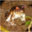

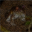

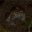

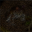

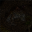

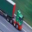

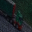

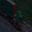

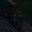

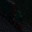

131740031it [00:02, 57025997.73it/s]


Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


14028800it [00:00, 47490376.96it/s]


Extracting data/caltech101/Annotations.tar to data/caltech101


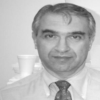

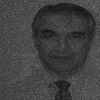

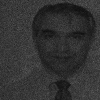

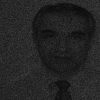

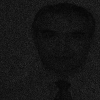

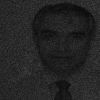

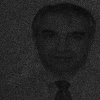

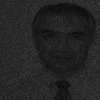

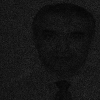

In [ ]:
# inspired by https://note.nkmk.me/en/python-pillow-concat-images/
def concat_imgs(imglst):
    totWidth = sum([img.width for img in imglst])
    out = Image.new('RGB', (totWidth, imglst[0].height))
    currWidth = 0
    for img in imglst:
        out.paste(img, (currWidth, 0))
        currWidth += img.width
    return out

cifar = CIFAR10(train=True, transform=None)

# first image in CIFAR-10
cifar_lst = []
img = cifar[0][0]
cifar_lst.append(img)
for brightness in reversed([30, 50, 70, 90]):
  newimg = make_night_img(np.array(img), brightness)
  newimg = Image.fromarray(newimg)
  cifar_lst.append(newimg)
concat_imgs(cifar_lst).show()
print("\n")

# 50th image in CIFAR-10
cifar_lst = []
img = cifar[50][0]
cifar_lst.append(img)
for brightness in reversed([30, 50, 70, 90]):
  newimg = make_night_img(np.array(img), brightness)
  newimg = Image.fromarray(newimg)
  cifar_lst.append(newimg)
concat_imgs(cifar_lst).show()
print("\n")


caltech = CALTECH101(train=True, transform=None)

# 100th image in Caltech101
cal_lst = []
img = caltech[100][0]
cal_lst.append(img)
for brightness in reversed([30, 50, 70, 90]):
  newimg = make_night_img(np.array(img), brightness)
  newimg = Image.fromarray(newimg)
  cal_lst.append(newimg)
concat_imgs(cal_lst).show()
print("\n")

# 200th image in Caltech101
cal_lst = []
img = caltech[100][0]
cal_lst.append(img)
for brightness in reversed([30, 50, 70, 90]):
  newimg = make_night_img(np.array(img), brightness)
  newimg = Image.fromarray(newimg)
  cal_lst.append(newimg)
concat_imgs(cal_lst).show()
print("\n")

# Experiments
Do not run the below cells! Results are already generated and attached.

## CIFAR10-Resnet50 Experiments


Gauss condition, resnet50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.2341 Acc: 0.5701
val Loss: 0.8088 Acc: 0.7464
Epoch 2/20
----------
train Loss: 0.6965 Acc: 0.7639
val Loss: 0.8569 Acc: 0.7972
Epoch 3/20
----------
train Loss: 0.5272 Acc: 0.8196
val Loss: 0.5613 Acc: 0.8258
Epoch 4/20
----------
train Loss: 0.4202 Acc: 0.8561
val Loss: 0.6451 Acc: 0.8290
Epoch 5/20
----------
train Loss: 0.3344 Acc: 0.8866
val Loss: 0.9438 Acc: 0.8186
Epoch 6/20
----------
train Loss: 0.2454 Acc: 0.9172
val Loss: 0.6430 Acc: 0.8422
Epoch 7/20
----------
train Loss: 0.2163 Acc: 0.9275
val Loss: 0.7099 Acc: 0.8402
Epoch 8/20
----------
train Loss: 0.2063 Acc: 0.9306
val Loss: 0.5880 Acc: 0.8480
Epoch 9/20
----------
train Loss: 0.1961 Acc: 0.9340
val Loss: 0.6821 Acc: 0.8400
Epoch 10/20
----------
train Loss: 0.1873 Acc: 0.9378
val Loss: 0.6359 Acc: 0.8468
Epoch 11/20
----------
train Loss: 0.1743 Acc: 0.9409
val Loss: 0.7071 Acc: 0.8444
Epoch 12

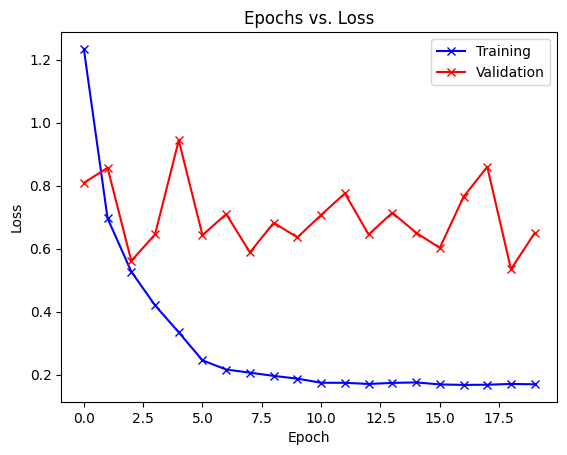

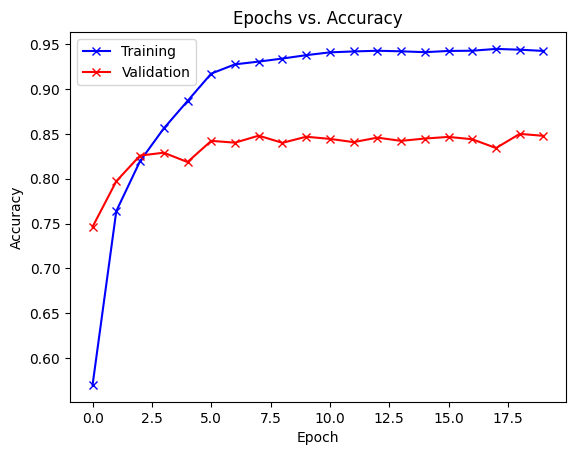

Files already downloaded and verified

Test Loss: 12.3003
Test Accuracy: 0.2565


In [ ]:
# "Gauss" condition
transform = compose_tensor(A.GaussNoise())
run_experiment("resnet50", "cifar10", transform, n_epochs, "Gauss")


Brightness condition, resnet50 model, cifar10 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.2743 Acc: 0.5526
val Loss: 0.8529 Acc: 0.7294
Epoch 2/20
----------
train Loss: 0.7441 Acc: 0.7442
val Loss: 0.6929 Acc: 0.7914
Epoch 3/20
----------
train Loss: 0.5672 Acc: 0.8045
val Loss: 0.5614 Acc: 0.8244
Epoch 4/20
----------
train Loss: 0.5259 Acc: 0.8183
val Loss: 0.6197 Acc: 0.8176
Epoch 5/20
----------
train Loss: 0.4134 Acc: 0.8583
val Loss: 0.5557 Acc: 0.8426
Epoch 6/20
----------
train Loss: 0.3144 Acc: 0.8922
val Loss: 1.0163 Acc: 0.8376
Epoch 7/20
----------
train Loss: 0.2924 Acc: 0.9005
val Loss: 0.6687 Acc: 0.8500
Epoch 8/20
----------
train Loss: 0.2701 Acc: 0.9072
val Loss: 0.8148 Acc: 0.8468
Epoch 9/20
----------
train Loss: 0.2600 Acc: 0.9104
val Loss: 0.9696 Acc: 0.8490
Epoch 10/20
----------
train Loss: 0.2504 Acc: 0.9126
val Loss: 0.6492 Acc: 0.8548
Epoch 11/20
----------
train Loss: 0.2343 Acc: 0.9222
val Loss: 0.9822 Acc: 0.8494
Epoch 12/20
----------
train Loss: 0.2350 Acc: 0.9189
val 

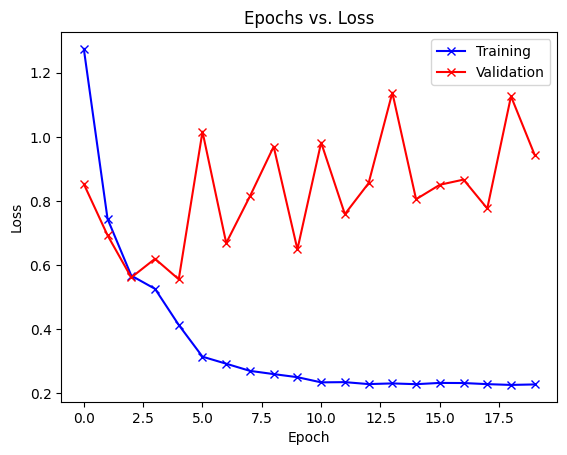

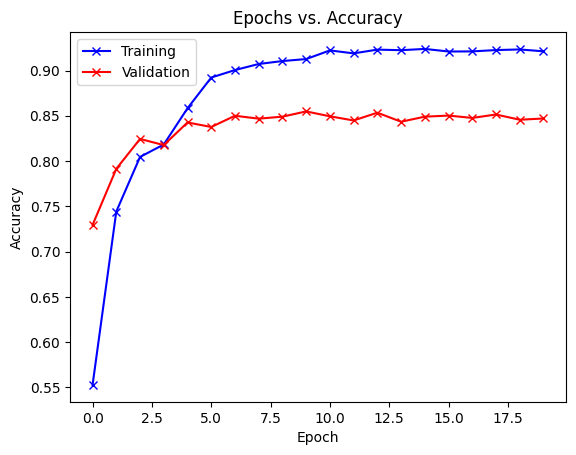

Files already downloaded and verified

Test Loss: 16.3315
Test Accuracy: 0.3292


In [ ]:
# "Brightness" condition
transform = compose_tensor(A.RandomBrightness())
run_experiment("resnet50", "cifar10", transform, n_epochs, "Brightness")


Contrast condition, resnet50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.2598 Acc: 0.5622
val Loss: 0.7911 Acc: 0.7376
Epoch 2/20
----------
train Loss: 0.6998 Acc: 0.7634
val Loss: 0.6277 Acc: 0.7862
Epoch 3/20
----------
train Loss: 0.5328 Acc: 0.8176
val Loss: 0.5262 Acc: 0.8240
Epoch 4/20
----------
train Loss: 0.4157 Acc: 0.8574
val Loss: 0.5421 Acc: 0.8306
Epoch 5/20
----------
train Loss: 0.3270 Acc: 0.8890
val Loss: 0.4929 Acc: 0.8474
Epoch 6/20
----------
train Loss: 0.2324 Acc: 0.9213
val Loss: 0.4895 Acc: 0.8472
Epoch 7/20
----------
train Loss: 0.2138 Acc: 0.9282
val Loss: 0.4838 Acc: 0.8522
Epoch 8/20
----------
train Loss: 0.1998 Acc: 0.9323
val Loss: 0.5200 Acc: 0.8452
Epoch 9/20
----------
train Loss: 0.1885 Acc: 0.9370
val Loss: 0.4649 Acc: 0.8534
Epoch 10/20
----------
train Loss: 0.1775 Acc: 0.9399
val Loss: 0.4812 Acc: 0.8548
Epoch 11/20
----------
train Loss: 0.1645 Acc: 0.9446
val Loss: 0.4821 Acc: 0.8518
Epoch

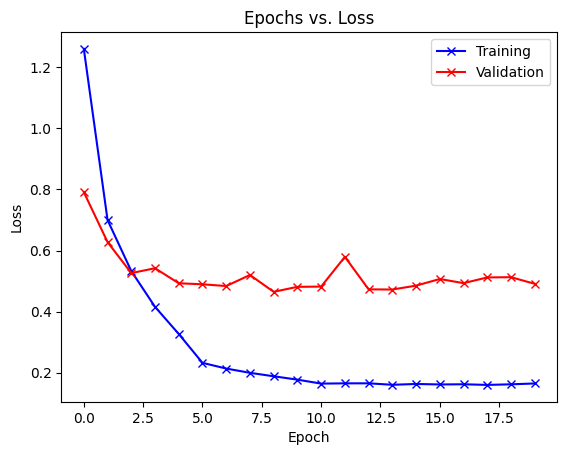

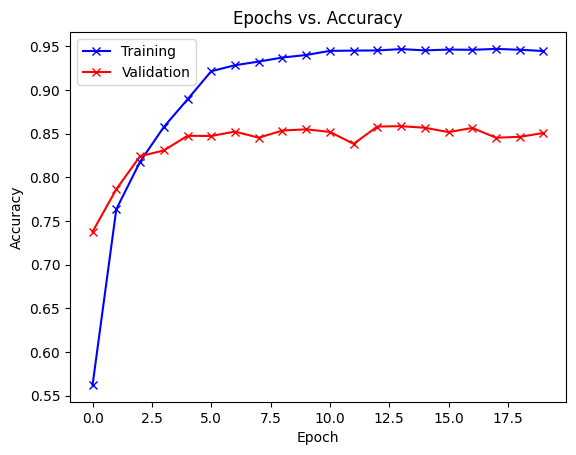

Files already downloaded and verified

Test Loss: 2.7414
Test Accuracy: 0.3572


In [ ]:
# "Contrast" condition
transform = compose_tensor(A.RandomContrast())
run_experiment("resnet50", "cifar10", transform, n_epochs, "Contrast")


BrightnessContrast condition, resnet50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.2584 Acc: 0.5627
val Loss: 0.8749 Acc: 0.7326
Epoch 2/20
----------
train Loss: 0.7308 Acc: 0.7518
val Loss: 0.7417 Acc: 0.7750
Epoch 3/20
----------
train Loss: 0.5834 Acc: 0.8008
val Loss: 1.2206 Acc: 0.7996
Epoch 4/20
----------
train Loss: 0.4596 Acc: 0.8436
val Loss: 0.7643 Acc: 0.8240
Epoch 5/20
----------
train Loss: 0.3624 Acc: 0.8752
val Loss: 1.0054 Acc: 0.8286
Epoch 6/20
----------
train Loss: 0.2687 Acc: 0.9080
val Loss: 0.7208 Acc: 0.8414
Epoch 7/20
----------
train Loss: 0.2434 Acc: 0.9180
val Loss: 1.3824 Acc: 0.8360
Epoch 8/20
----------
train Loss: 0.2327 Acc: 0.9223
val Loss: 1.8525 Acc: 0.8284
Epoch 9/20
----------
train Loss: 0.2171 Acc: 0.9280
val Loss: 1.1057 Acc: 0.8388
Epoch 10/20
----------
train Loss: 0.2097 Acc: 0.9294
val Loss: 0.8053 Acc: 0.8390
Epoch 11/20
----------
train Loss: 0.1978 Acc: 0.9333
val Loss: 2.1640 Acc: 0.

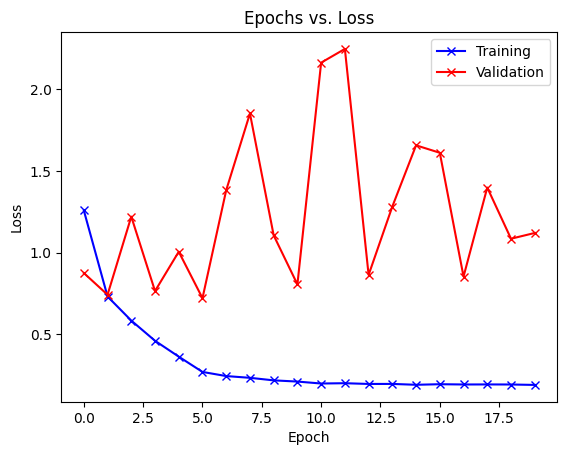

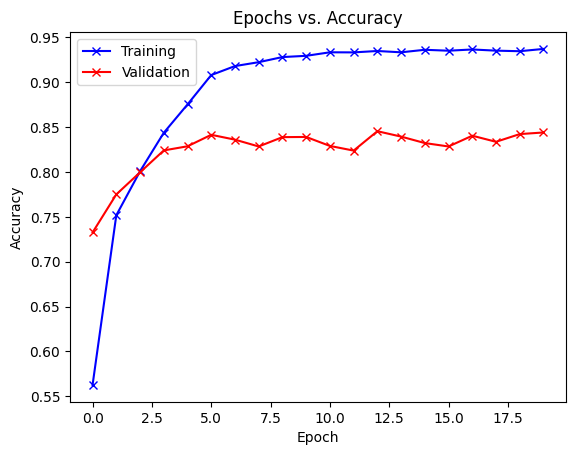

Files already downloaded and verified

Test Loss: 2.4987
Test Accuracy: 0.3956


In [ ]:
# "BrightnessContrast" condition
transform = compose_tensor(A.RandomBrightnessContrast())
run_experiment("resnet50", "cifar10", transform, n_epochs, "BrightnessContrast")


Control condition, resnet50 model, cifar10 dataset


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.3MB/s]


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3201 Acc: 0.5351
val Loss: 0.8117 Acc: 0.7254
Epoch 2/20
----------
train Loss: 0.7267 Acc: 0.7534
val Loss: 0.5777 Acc: 0.8020
Epoch 3/20
----------
train Loss: 0.5357 Acc: 0.8186
val Loss: 0.5391 Acc: 0.8166
Epoch 4/20
----------
train Loss: 0.4258 Acc: 0.8538
val Loss: 0.5012 Acc: 0.8334
Epoch 5/20
----------
train Loss: 0.3362 Acc: 0.8864
val Loss: 0.5046 Acc: 0.8352
Epoch 6/20
----------
train Loss: 0.2405 Acc: 0.9190
val Loss: 0.5025 Acc: 0.8332
Epoch 7/20
----------
train Loss: 0.2190 Acc: 0.9251
val Loss: 0.5001 Acc: 0.8402
Epoch 8/20
----------
train Loss: 0.1999 Acc: 0.9337
val Loss: 0.4967 Acc: 0.8396
Epoch 9/20
----------
train Loss: 0.1885 Acc: 0.9358
val Loss: 0.4987 Acc: 0.8378
Epoch 10/20
----------
train Loss: 0.1776 Acc: 0.9406
val Loss: 0.5128 Acc: 0.8380
Epoch 11/20
----------
train Loss: 0.1669 Acc: 0.9444
val Loss: 0.4957 Acc: 0.8396
Epoch 12/20
----------
train Loss: 0.1689 Acc: 0.9433
val 

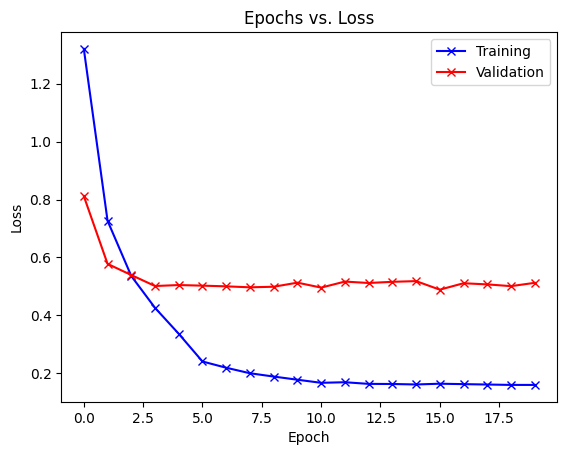

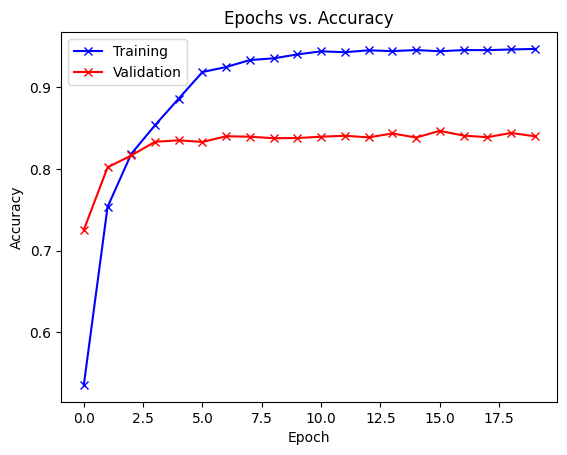

Files already downloaded and verified

Test Loss: 2.7762
Test Accuracy: 0.3539


In [ ]:
# "Control" condition
run_experiment("resnet50", "cifar10", ToTensorV2(), n_epochs, "Control")


Normalize condition, resnet50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.2130 Acc: 0.5780
val Loss: 0.7532 Acc: 0.7544
Epoch 2/20
----------
train Loss: 0.6684 Acc: 0.7760
val Loss: 0.5761 Acc: 0.8058
Epoch 3/20
----------
train Loss: 0.4853 Acc: 0.8367
val Loss: 0.5212 Acc: 0.8272
Epoch 4/20
----------
train Loss: 0.3731 Acc: 0.8746
val Loss: 0.4818 Acc: 0.8378
Epoch 5/20
----------
train Loss: 0.2895 Acc: 0.9017
val Loss: 0.4891 Acc: 0.8458
Epoch 6/20
----------
train Loss: 0.2032 Acc: 0.9325
val Loss: 0.4889 Acc: 0.8506
Epoch 7/20
----------
train Loss: 0.1839 Acc: 0.9379
val Loss: 0.4849 Acc: 0.8518
Epoch 8/20
----------
train Loss: 0.1690 Acc: 0.9424
val Loss: 0.4904 Acc: 0.8520
Epoch 9/20
----------
train Loss: 0.1587 Acc: 0.9474
val Loss: 0.4669 Acc: 0.8548
Epoch 10/20
----------
train Loss: 0.1499 Acc: 0.9502
val Loss: 0.4771 Acc: 0.8524
Epoch 11/20
----------
train Loss: 0.1439 Acc: 0.9525
val Loss: 0.4966 Acc: 0.8474
Epoc

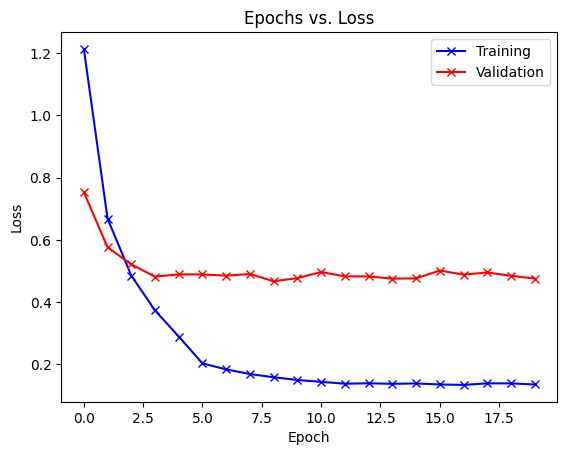

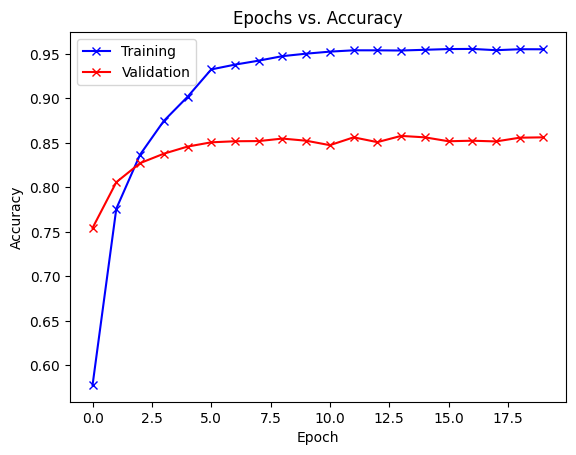

Files already downloaded and verified

Test Loss: 7.1758
Test Accuracy: 0.1165


In [ ]:
# "Normalize" condition
transform = compose_tensor(A.Normalize())
run_experiment("resnet50", "cifar10", transform, n_epochs, "Normalize")


randPPP condition, resnet50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3952 Acc: 0.5052
val Loss: 0.9148 Acc: 0.6996
Epoch 2/20
----------
train Loss: 0.8651 Acc: 0.7030
val Loss: 0.8776 Acc: 0.7506
Epoch 3/20
----------
train Loss: 0.6972 Acc: 0.7597
val Loss: 0.8446 Acc: 0.7814
Epoch 4/20
----------
train Loss: 0.5860 Acc: 0.7976
val Loss: 0.9893 Acc: 0.7922
Epoch 5/20
----------
train Loss: 0.5170 Acc: 0.8250
val Loss: 0.6921 Acc: 0.8064
Epoch 6/20
----------
train Loss: 0.4237 Acc: 0.8556
val Loss: 1.1219 Acc: 0.7948
Epoch 7/20
----------
train Loss: 0.4025 Acc: 0.8613
val Loss: 0.7351 Acc: 0.8212
Epoch 8/20
----------
train Loss: 0.3901 Acc: 0.8654
val Loss: 1.4711 Acc: 0.8016
Epoch 9/20
----------
train Loss: 0.3779 Acc: 0.8700
val Loss: 0.7543 Acc: 0.8154
Epoch 10/20
----------
train Loss: 0.3671 Acc: 0.8728
val Loss: 1.0811 Acc: 0.8124
Epoch 11/20
----------
train Loss: 0.3570 Acc: 0.8769
val Loss: 0.8948 Acc: 0.8146
Epoch 

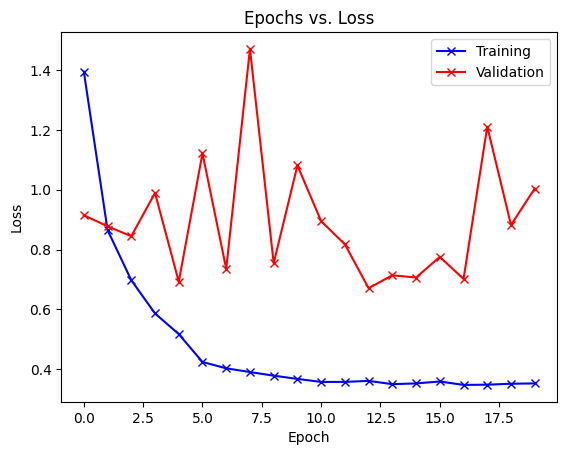

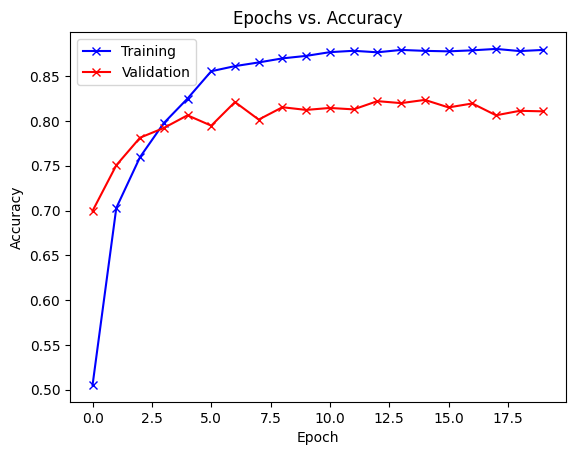

Files already downloaded and verified

Test Loss: 0.5374
Test Accuracy: 0.8276


In [ ]:
# "RandPPP" condition
transform = compose_tensor(A.Lambda(random_PPP))
run_experiment("resnet50", "cifar10", transform, n_epochs, "randPPP")

## CIFAR10-ResneXt50 Experiments


Gauss condition, resnext50 model, cifar10 dataset


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 196MB/s]


100%|██████████| 170498071/170498071 [00:12<00:00, 13233972.20it/s]


Extracting data/cifar-10-python.tar.gz to data
Epoch 1/20
----------
train Loss: 1.4232 Acc: 0.4927
val Loss: 1.1066 Acc: 0.6874
Epoch 2/20
----------
train Loss: 0.8597 Acc: 0.7084
val Loss: 0.6907 Acc: 0.7644
Epoch 3/20
----------
train Loss: 0.6644 Acc: 0.7732
val Loss: 0.6006 Acc: 0.7990
Epoch 4/20
----------
train Loss: 0.5479 Acc: 0.8137
val Loss: 0.5579 Acc: 0.8118
Epoch 5/20
----------
train Loss: 0.4519 Acc: 0.8455
val Loss: 0.5464 Acc: 0.8188
Epoch 6/20
----------
train Loss: 0.3632 Acc: 0.8758
val Loss: 0.5274 Acc: 0.8256
Epoch 7/20
----------
train Loss: 0.3411 Acc: 0.8848
val Loss: 0.5230 Acc: 0.8228
Epoch 8/20
----------
train Loss: 0.3218 Acc: 0.8895
val Loss: 0.5255 Acc: 0.8290
Epoch 9/20
----------
train Loss: 0.3091 Acc: 0.8933
val Loss: 0.5192 Acc: 0.8342
Epoch 10/20
----------
train Loss: 0.3019 Acc: 0.8963
val Loss: 0.5280 Acc: 0.8256
Epoch 11/20
----------
train Loss: 0.2851 Acc: 0.9032
val Loss: 0.5140 Acc: 0.8308
Epoch 12/20
----------
train Loss: 0.2920 Acc: 0.

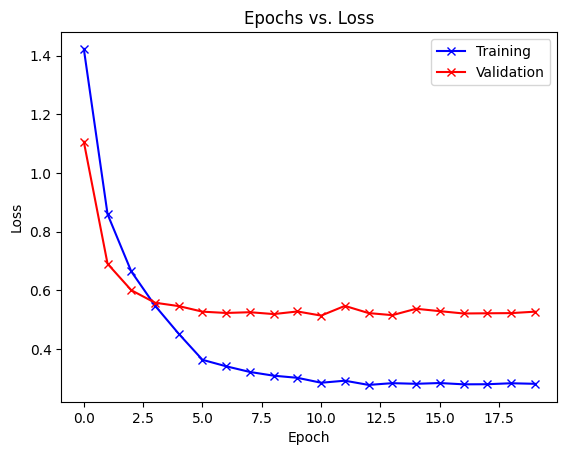

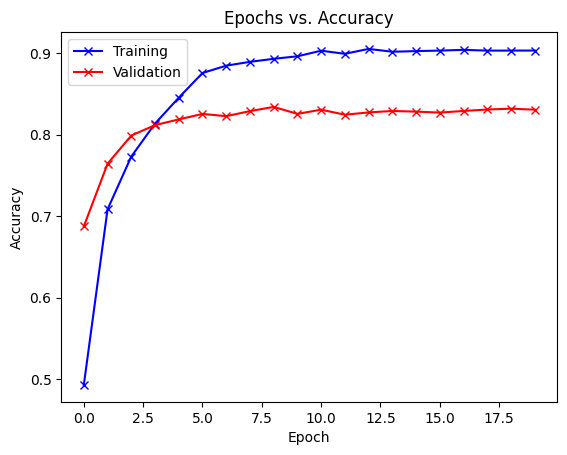

Files already downloaded and verified

Test Loss: 2.1047
Test Accuracy: 0.4061


In [ ]:
# "Gauss" condition
transform = compose_tensor(A.GaussNoise())
run_experiment("resnext50", "cifar10", transform, n_epochs, "Gauss")


Brightness condition, resnext50 model, cifar10 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3827 Acc: 0.5116
val Loss: 1.4315 Acc: 0.6898
Epoch 2/20
----------
train Loss: 0.8624 Acc: 0.7034
val Loss: 1.0218 Acc: 0.7400
Epoch 3/20
----------
train Loss: 0.6894 Acc: 0.7627
val Loss: 0.8364 Acc: 0.7850
Epoch 4/20
----------
train Loss: 0.5757 Acc: 0.8017
val Loss: 1.8003 Acc: 0.7828
Epoch 5/20
----------
train Loss: 0.5347 Acc: 0.8167
val Loss: 0.9516 Acc: 0.7562
Epoch 6/20
----------
train Loss: 0.5900 Acc: 0.7980
val Loss: 1.0603 Acc: 0.7886
Epoch 7/20
----------
train Loss: 0.5219 Acc: 0.8178
val Loss: 0.8484 Acc: 0.7908
Epoch 8/20
----------
train Loss: 0.4876 Acc: 0.8306
val Loss: 0.9626 Acc: 0.7988
Epoch 9/20
----------
train Loss: 0.4601 Acc: 0.8380
val Loss: 0.7582 Acc: 0.8036
Epoch 10/20
----------
train Loss: 0.4413 Acc: 0.8467
val Loss: 0.7235 Acc: 0.8076
Epoch 11/20
----------
train Loss: 0.4299 Acc: 0.8498
val Loss: 0.7182 Acc: 0.8114
Epoch 12/20
----------
train Loss: 0.4229 Acc: 0.8529
val 

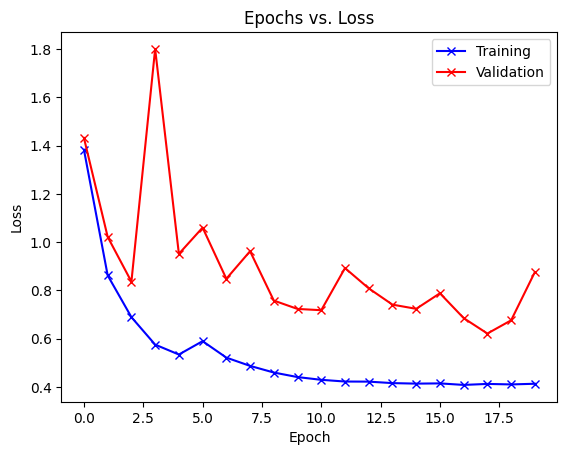

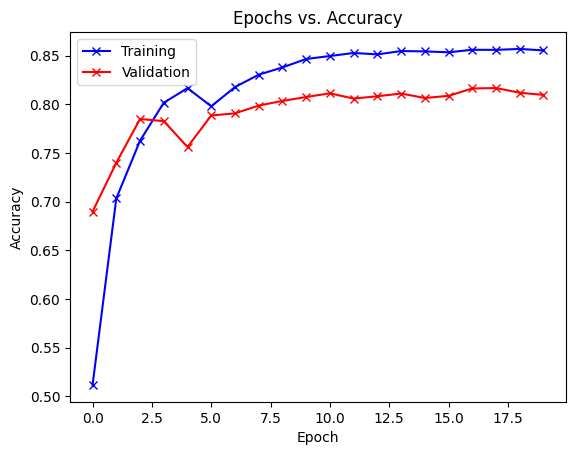

Files already downloaded and verified

Test Loss: 2.8795
Test Accuracy: 0.2222


In [ ]:
# "Brightness" condition
transform = compose_tensor(A.RandomBrightness())
run_experiment("resnext50", "cifar10", transform, n_epochs, "Brightness")


Brightness condition, resnext50 model, cifar10 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3522 Acc: 0.5196
val Loss: 0.9086 Acc: 0.6844
Epoch 2/20
----------
train Loss: 0.8285 Acc: 0.7173
val Loss: 0.9116 Acc: 0.7606
Epoch 3/20
----------
train Loss: 0.6518 Acc: 0.7770
val Loss: 0.8083 Acc: 0.7794
Epoch 4/20
----------
train Loss: 0.5442 Acc: 0.8116
val Loss: 0.8603 Acc: 0.7944
Epoch 5/20
----------
train Loss: 0.4622 Acc: 0.8407
val Loss: 0.7033 Acc: 0.8078
Epoch 6/20
----------
train Loss: 0.3650 Acc: 0.8726
val Loss: 0.5972 Acc: 0.8196
Epoch 7/20
----------
train Loss: 0.3517 Acc: 0.8776
val Loss: 0.6499 Acc: 0.8134
Epoch 8/20
----------
train Loss: 0.3314 Acc: 0.8856
val Loss: 0.7835 Acc: 0.8172
Epoch 9/20
----------
train Loss: 0.3243 Acc: 0.8857
val Loss: 0.7734 Acc: 0.8174
Epoch 10/20
----------
train Loss: 0.3186 Acc: 0.8878
val Loss: 0.9061 Acc: 0.8160
Epoch 11/20
----------
train Loss: 0.3065 Acc: 0.8931
val Loss: 1.0312 Acc: 0.8168
Epoch 12/20
----------
train Loss: 0.3020 Acc: 0.8937
val 

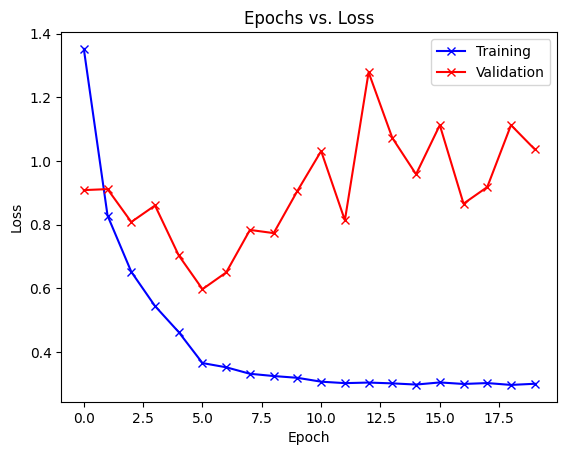

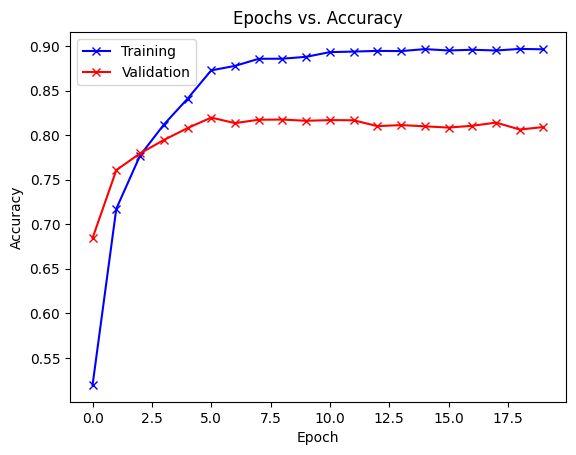

Files already downloaded and verified

Test Loss: 2.8912
Test Accuracy: 0.3097


In [ ]:
# "Contrast" condition
transform = compose_tensor(A.RandomContrast())
run_experiment("resnext50", "cifar10", transform, n_epochs, "Contrast")


Brightness condition, resnext50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.4273 Acc: 0.4944
val Loss: 0.9103 Acc: 0.6912
Epoch 2/20
----------
train Loss: 0.8495 Acc: 0.7100
val Loss: 0.7290 Acc: 0.7548
Epoch 3/20
----------
train Loss: 0.6594 Acc: 0.7776
val Loss: 0.6198 Acc: 0.7894
Epoch 4/20
----------
train Loss: 0.5396 Acc: 0.8172
val Loss: 0.5879 Acc: 0.8006
Epoch 5/20
----------
train Loss: 0.4549 Acc: 0.8453
val Loss: 0.5542 Acc: 0.8176
Epoch 6/20
----------
train Loss: 0.3589 Acc: 0.8781
val Loss: 0.5475 Acc: 0.8164
Epoch 7/20
----------
train Loss: 0.3396 Acc: 0.8848
val Loss: 0.5592 Acc: 0.8144
Epoch 8/20
----------
train Loss: 0.3202 Acc: 0.8907
val Loss: 0.5515 Acc: 0.8222
Epoch 9/20
----------
train Loss: 0.3036 Acc: 0.8956
val Loss: 0.5499 Acc: 0.8208
Epoch 10/20
----------
train Loss: 0.2977 Acc: 0.8980
val Loss: 0.5474 Acc: 0.8270
Epoch 11/20
----------
train Loss: 0.2907 Acc: 0.9004
val Loss: 0.5439 Acc: 0.8292
Ep

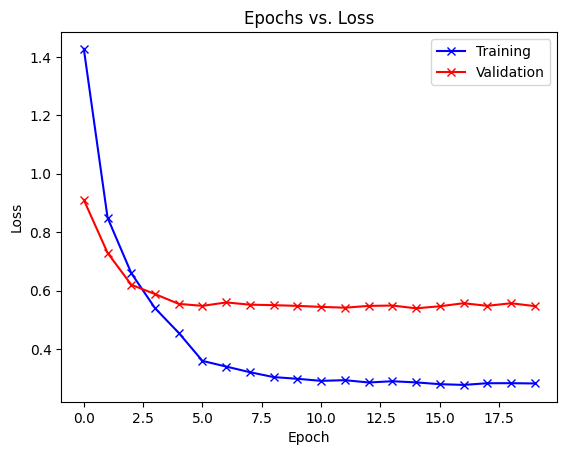

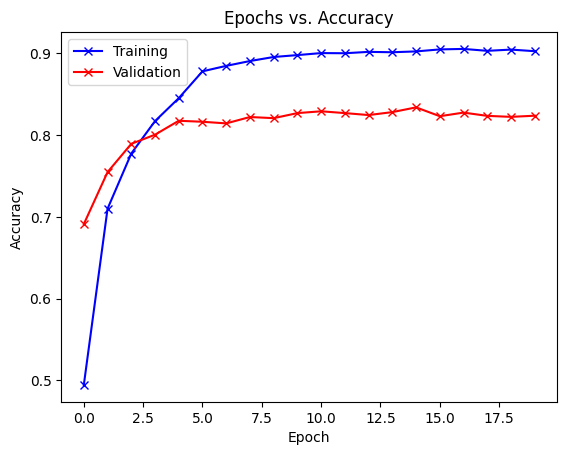

Files already downloaded and verified

Test Loss: 2.4364
Test Accuracy: 0.4045


In [ ]:
# "BrightnessContrast" condition
transform = compose_tensor(A.RandomBrightnessContrast())
run_experiment("resnext50", "cifar10", transform, n_epochs, "BrightnessContrast")


Control condition, resnext50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3643 Acc: 0.5234
val Loss: 0.9066 Acc: 0.6902
Epoch 2/20
----------
train Loss: 0.8194 Acc: 0.7246
val Loss: 0.6885 Acc: 0.7634
Epoch 3/20
----------
train Loss: 0.6349 Acc: 0.7867
val Loss: 0.6044 Acc: 0.7954
Epoch 4/20
----------
train Loss: 0.5152 Acc: 0.8258
val Loss: 0.5931 Acc: 0.8060
Epoch 5/20
----------
train Loss: 0.4191 Acc: 0.8582
val Loss: 0.5331 Acc: 0.8230
Epoch 6/20
----------
train Loss: 0.3271 Acc: 0.8899
val Loss: 0.5400 Acc: 0.8266
Epoch 7/20
----------
train Loss: 0.3004 Acc: 0.8984
val Loss: 0.5544 Acc: 0.8272
Epoch 8/20
----------
train Loss: 0.2944 Acc: 0.8991
val Loss: 0.5452 Acc: 0.8280
Epoch 9/20
----------
train Loss: 0.2768 Acc: 0.9063
val Loss: 0.5427 Acc: 0.8288
Epoch 10/20
----------
train Loss: 0.2658 Acc: 0.9102
val Loss: 0.5435 Acc: 0.8322
Epoch 11/20
----------
train Loss: 0.2565 Acc: 0.9127
val Loss: 0.5489 Acc: 0.8314
Epoch

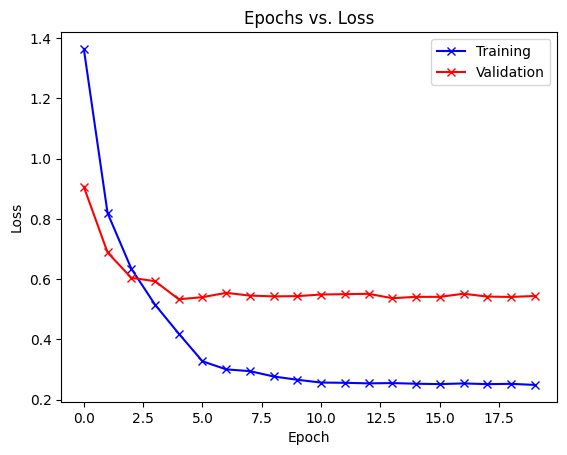

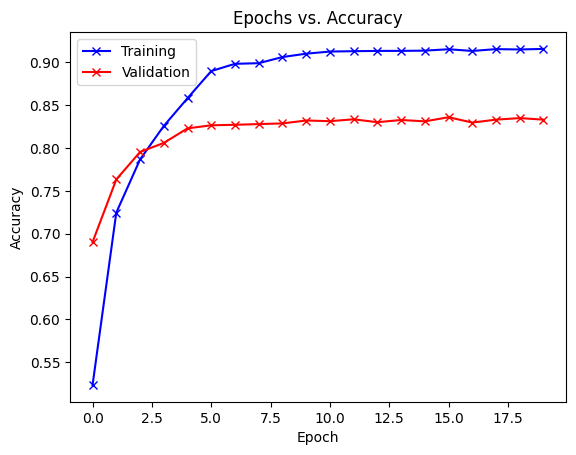

Files already downloaded and verified

Test Loss: 2.4326
Test Accuracy: 0.3855


In [ ]:
# "Control" condition
run_experiment("resnext50", "cifar10", ToTensorV2(), n_epochs, "Control")


Normalize condition, resnext50 model, cifar10 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 1.3623 Acc: 0.5246
val Loss: 0.9450 Acc: 0.6790
Epoch 2/20
----------
train Loss: 0.8539 Acc: 0.7077
val Loss: 0.7057 Acc: 0.7520
Epoch 3/20
----------
train Loss: 0.6673 Acc: 0.7714
val Loss: 0.6331 Acc: 0.7876
Epoch 4/20
----------
train Loss: 0.5474 Acc: 0.8125
val Loss: 0.6015 Acc: 0.7964
Epoch 5/20
----------
train Loss: 0.4652 Acc: 0.8388
val Loss: 0.5730 Acc: 0.8134
Epoch 6/20
----------
train Loss: 0.3688 Acc: 0.8733
val Loss: 0.6592 Acc: 0.8216
Epoch 7/20
----------
train Loss: 0.3530 Acc: 0.8783
val Loss: 0.6962 Acc: 0.8176
Epoch 8/20
----------
train Loss: 0.3273 Acc: 0.8889
val Loss: 0.6628 Acc: 0.8232
Epoch 9/20
----------
train Loss: 0.3152 Acc: 0.8910
val Loss: 0.5642 Acc: 0.8324
Epoch 10/20
----------
train Loss: 0.2975 Acc: 0.8961
val Loss: 0.6899 Acc: 0.8146
Epoch 11/20
----------
train Loss: 0.2868 Acc: 0.9011
val Loss: 0.6122 Acc: 0.8238
Epo

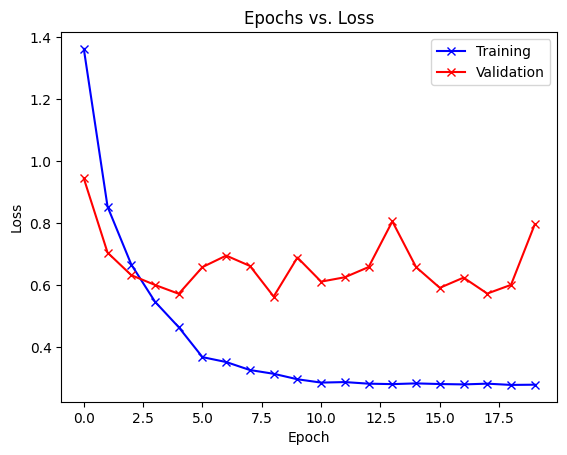

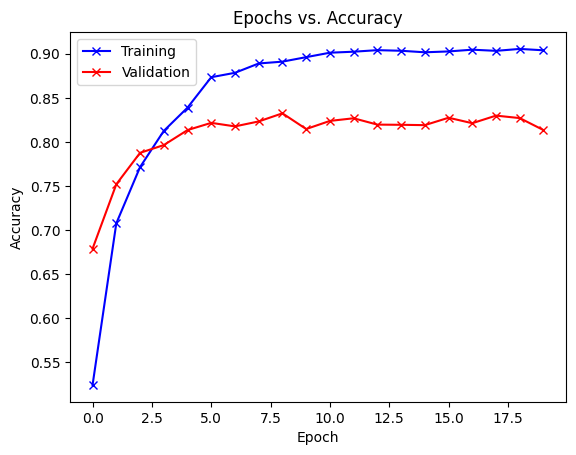

Files already downloaded and verified

Test Loss: 20801.9990
Test Accuracy: 0.1000


In [ ]:
# "Normalize" condition
transform = compose_tensor(A.Normalize())
run_experiment("resnext50", "cifar10", transform, n_epochs, "Normalize")

In [ ]:
# "RandPPP" condition
transform = compose_tensor(A.Lambda(random_PPP))
run_experiment("resnext50", "cifar10", transform, n_epochs, "randPPP")


randPPP condition, resnext50 model, cifar10 dataset


100%|██████████| 170498071/170498071 [00:13<00:00, 12808225.89it/s]


Extracting data/cifar-10-python.tar.gz to data
Epoch 1/20
----------
train Loss: 1.5115 Acc: 0.4565
val Loss: 1.0739 Acc: 0.6218
Epoch 2/20
----------
train Loss: 0.9964 Acc: 0.6566
val Loss: 0.9760 Acc: 0.6826
Epoch 3/20
----------
train Loss: 0.8205 Acc: 0.7173
val Loss: 0.7489 Acc: 0.7422
Epoch 4/20
----------
train Loss: 0.7110 Acc: 0.7584
val Loss: 0.7162 Acc: 0.7564
Epoch 5/20
----------
train Loss: 0.6415 Acc: 0.7819
val Loss: 0.6646 Acc: 0.7732
Epoch 6/20
----------
train Loss: 0.5499 Acc: 0.8120
val Loss: 1.9287 Acc: 0.7816
Epoch 7/20
----------
train Loss: 0.5334 Acc: 0.8155
val Loss: 0.6781 Acc: 0.7828
Epoch 8/20
----------
train Loss: 0.5086 Acc: 0.8253
val Loss: 1.3370 Acc: 0.7836
Epoch 9/20
----------
train Loss: 0.5099 Acc: 0.8257
val Loss: 0.6361 Acc: 0.7914
Epoch 10/20
----------
train Loss: 0.4928 Acc: 0.8305
val Loss: 0.8205 Acc: 0.7878
Epoch 11/20
----------
train Loss: 0.4856 Acc: 0.8337
val Loss: 0.6264 Acc: 0.7842
Epoch 12/20
----------
train Loss: 0.4872 Acc: 0.

## Caltech101-Resnet50 Experiments


Gauss condition, resnet50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2524 Acc: 0.3458
val Loss: 2.3730 Acc: 0.5698
Epoch 2/20
----------
train Loss: 1.6083 Acc: 0.6500
val Loss: 1.0947 Acc: 0.7453
Epoch 3/20
----------
train Loss: 0.9577 Acc: 0.7690
val Loss: 0.8993 Acc: 0.7626
Epoch 4/20
----------
train Loss: 0.7553 Acc: 0.8037
val Loss: 0.6911 Acc: 0.8216
Epoch 5/20
----------
train Loss: 0.6366 Acc: 0.8321
val Loss: 0.6829 Acc: 0.8187
Epoch 6/20
----------
train Loss: 0.5725 Acc: 0.8548
val Loss: 0.6346 Acc: 0.8288
Epoch 7/20
----------
train Loss: 0.5903 Acc: 0.8433
val Loss: 0.6293 Acc: 0.8345
Epoch 8/20
----------
train Loss: 0.5548 Acc: 0.8543
val Loss: 0.5901 Acc: 0.8432
Epoch 9/20
----------
train Loss: 0.5484 Acc: 0.8533
val Loss: 0.5834 Acc: 0.8403
Epoch 10/20
----------
train Loss: 0.5463 Acc: 0.8540
val Loss: 0.5446 Acc: 0.8561
Epoch 11/20
----------
train Loss: 0.5581 Acc: 0.8524
val Loss: 0.5260 Acc: 0.8576
Epoch

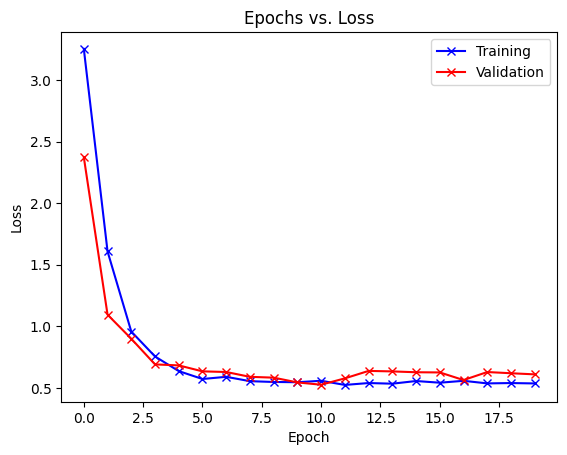

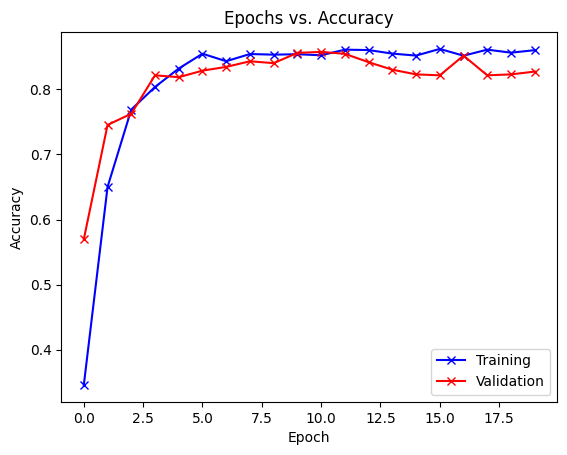

Files already downloaded and verified

Test Loss: 1.9702
Test Accuracy: 0.5294


In [ ]:
# "Gauss" condition
transform = compose_tensor(A.GaussNoise())
run_experiment("resnet50", "caltech101", transform, n_epochs, "Gauss")


Brightness condition, resnet50 model, caltech101 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2448 Acc: 0.3442
val Loss: 2.2283 Acc: 0.5741
Epoch 2/20
----------
train Loss: 1.6116 Acc: 0.6529
val Loss: 1.1542 Acc: 0.7194
Epoch 3/20
----------
train Loss: 0.9490 Acc: 0.7735
val Loss: 0.7930 Acc: 0.7928
Epoch 4/20
----------
train Loss: 0.7162 Acc: 0.8157
val Loss: 0.6399 Acc: 0.8144
Epoch 5/20
----------
train Loss: 0.6382 Acc: 0.8335
val Loss: 0.6066 Acc: 0.8345
Epoch 6/20
----------
train Loss: 0.5739 Acc: 0.8442
val Loss: 0.5854 Acc: 0.8230
Epoch 7/20
----------
train Loss: 0.6006 Acc: 0.8465
val Loss: 0.5734 Acc: 0.8388
Epoch 8/20
----------
train Loss: 0.5392 Acc: 0.8591
val Loss: 0.6093 Acc: 0.8158
Epoch 9/20
----------
train Loss: 0.5400 Acc: 0.8581
val Loss: 0.6256 Acc: 0.8230
Epoch 10/20
----------
train Loss: 0.5619 Acc: 0.8497
val Loss: 0.6194 Acc: 0.8345
Epoch 11/20
----------
train Loss: 0.5261 Acc: 0.8614
val Loss: 0.5573 Acc: 0.8245
Epoch 12/20
----------
train Loss: 0.5250 Acc: 0.8618
val 

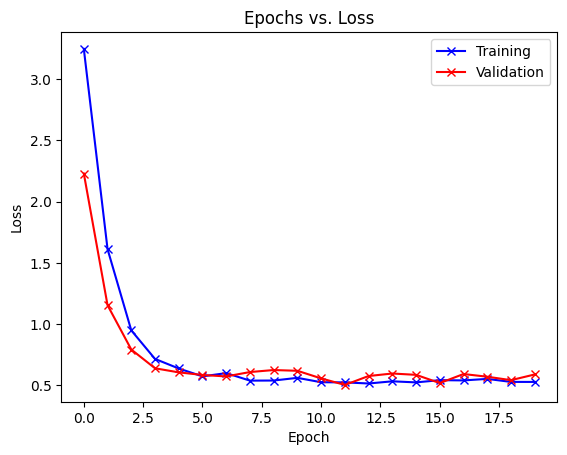

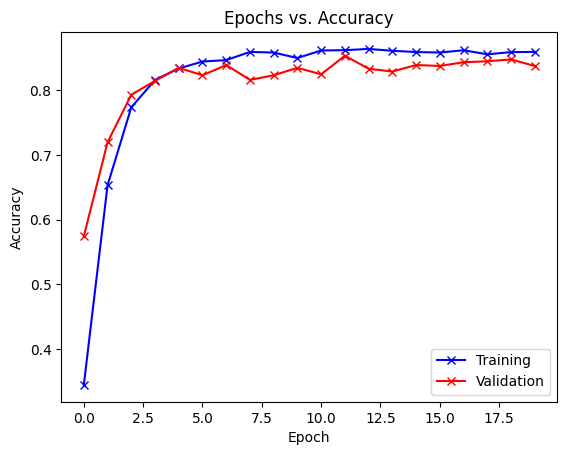

Files already downloaded and verified

Test Loss: 1.6081
Test Accuracy: 0.5991


In [ ]:
# "Brightness" condition
transform = compose_tensor(A.RandomBrightness())
run_experiment("resnet50", "caltech101", transform, n_epochs, "Brightness")


Brightness condition, resnet50 model, caltech101 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2371 Acc: 0.3511
val Loss: 2.1890 Acc: 0.5856
Epoch 2/20
----------
train Loss: 1.5669 Acc: 0.6633
val Loss: 1.0552 Acc: 0.7655
Epoch 3/20
----------
train Loss: 0.9341 Acc: 0.7688
val Loss: 0.7399 Acc: 0.8058
Epoch 4/20
----------
train Loss: 0.7479 Acc: 0.8072
val Loss: 0.6856 Acc: 0.8360
Epoch 5/20
----------
train Loss: 0.6434 Acc: 0.8237
val Loss: 0.6026 Acc: 0.8403
Epoch 6/20
----------
train Loss: 0.5696 Acc: 0.8565
val Loss: 0.5588 Acc: 0.8547
Epoch 7/20
----------
train Loss: 0.5501 Acc: 0.8514
val Loss: 0.5760 Acc: 0.8489
Epoch 8/20
----------
train Loss: 0.5521 Acc: 0.8572
val Loss: 0.5981 Acc: 0.8331
Epoch 9/20
----------
train Loss: 0.5326 Acc: 0.8594
val Loss: 0.5277 Acc: 0.8576
Epoch 10/20
----------
train Loss: 0.5256 Acc: 0.8607
val Loss: 0.5185 Acc: 0.8532
Epoch 11/20
----------
train Loss: 0.5404 Acc: 0.8580
val Loss: 0.5498 Acc: 0.8518
Epoch 12/20
----------
train Loss: 0.5419 Acc: 0.8543
val 

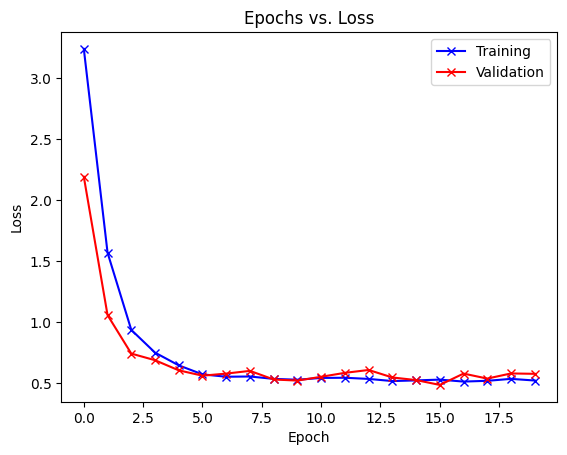

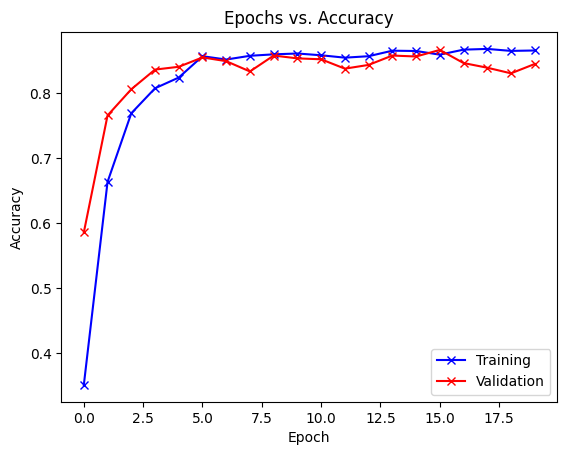

Files already downloaded and verified

Test Loss: 1.7771
Test Accuracy: 0.5829


In [ ]:
# "Contrast" condition
transform = compose_tensor(A.RandomContrast())
run_experiment("resnet50", "caltech101", transform, n_epochs, "Brightness")


Brightness condition, resnet50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2358 Acc: 0.3479
val Loss: 2.2752 Acc: 0.5669
Epoch 2/20
----------
train Loss: 1.6114 Acc: 0.6503
val Loss: 1.1502 Acc: 0.7439
Epoch 3/20
----------
train Loss: 0.9574 Acc: 0.7637
val Loss: 0.7885 Acc: 0.7813
Epoch 4/20
----------
train Loss: 0.7559 Acc: 0.8048
val Loss: 0.7342 Acc: 0.7856
Epoch 5/20
----------
train Loss: 0.6352 Acc: 0.8337
val Loss: 0.7219 Acc: 0.8101
Epoch 6/20
----------
train Loss: 0.5610 Acc: 0.8503
val Loss: 0.6541 Acc: 0.8259
Epoch 7/20
----------
train Loss: 0.5403 Acc: 0.8601
val Loss: 0.6030 Acc: 0.8360
Epoch 8/20
----------
train Loss: 0.5450 Acc: 0.8557
val Loss: 0.6479 Acc: 0.8187
Epoch 9/20
----------
train Loss: 0.5404 Acc: 0.8578
val Loss: 0.6305 Acc: 0.8360
Epoch 10/20
----------
train Loss: 0.5504 Acc: 0.8521
val Loss: 0.6101 Acc: 0.8331
Epoch 11/20
----------
train Loss: 0.5172 Acc: 0.8588
val Loss: 0.5948 Acc: 0.8288


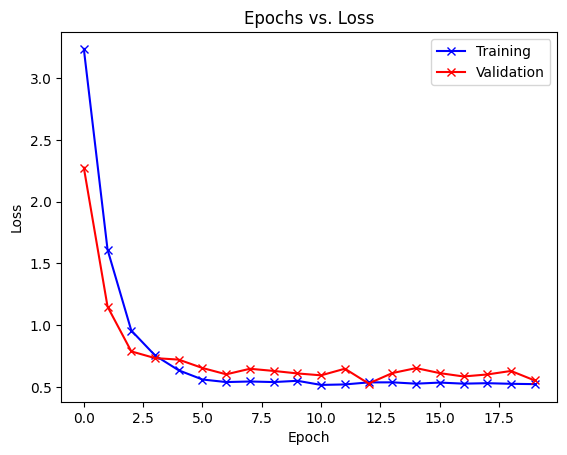

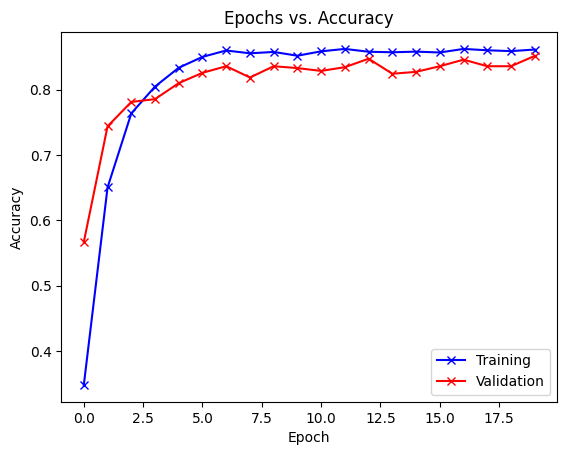

Files already downloaded and verified

Test Loss: 1.7261
Test Accuracy: 0.5795


In [ ]:
# "BrightnessContrast" condition
transform = compose_tensor(A.RandomBrightnessContrast())
run_experiment("resnet50", "caltech101", transform, n_epochs, "Brightness")


Control condition, resnet50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2014 Acc: 0.3622
val Loss: 2.1977 Acc: 0.5755
Epoch 2/20
----------
train Loss: 1.5382 Acc: 0.6734
val Loss: 1.0953 Acc: 0.7281
Epoch 3/20
----------
train Loss: 0.9455 Acc: 0.7654
val Loss: 0.8062 Acc: 0.7856
Epoch 4/20
----------
train Loss: 0.7238 Acc: 0.8127
val Loss: 0.6553 Acc: 0.8388
Epoch 5/20
----------
train Loss: 0.6233 Acc: 0.8381
val Loss: 0.6351 Acc: 0.8187
Epoch 6/20
----------
train Loss: 0.5427 Acc: 0.8538
val Loss: 0.6022 Acc: 0.8360
Epoch 7/20
----------
train Loss: 0.5462 Acc: 0.8609
val Loss: 0.6096 Acc: 0.8259
Epoch 8/20
----------
train Loss: 0.5140 Acc: 0.8668
val Loss: 0.6071 Acc: 0.8216
Epoch 9/20
----------
train Loss: 0.5291 Acc: 0.8630
val Loss: 0.5882 Acc: 0.8432
Epoch 10/20
----------
train Loss: 0.5202 Acc: 0.8622
val Loss: 0.5746 Acc: 0.8547
Epoch 11/20
----------
train Loss: 0.5057 Acc: 0.8666
val Loss: 0.5669 Acc: 0.8345
Epo

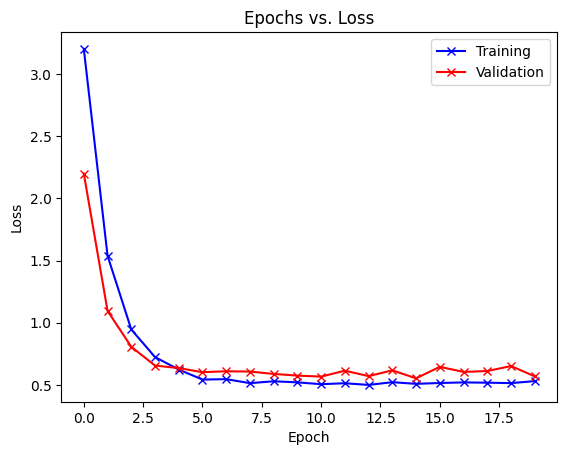

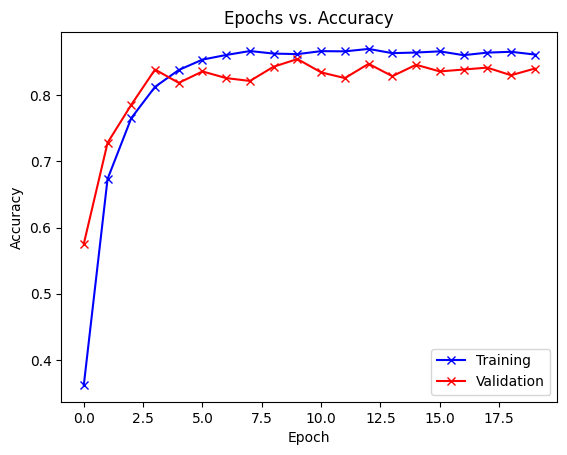

Files already downloaded and verified

Test Loss: 1.6339
Test Accuracy: 0.6008


In [ ]:
# "Control" condition
run_experiment("resnet50", "caltech101", ToTensorV2(), n_epochs, "Control")


Normalize condition, resnet50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2259 Acc: 0.3506
val Loss: 2.1914 Acc: 0.6086
Epoch 2/20
----------
train Loss: 1.5911 Acc: 0.6529
val Loss: 1.1167 Acc: 0.7482
Epoch 3/20
----------
train Loss: 0.9250 Acc: 0.7781
val Loss: 0.7577 Acc: 0.7928
Epoch 4/20
----------
train Loss: 0.7331 Acc: 0.8092
val Loss: 0.5749 Acc: 0.8460
Epoch 5/20
----------
train Loss: 0.6247 Acc: 0.8415
val Loss: 0.5605 Acc: 0.8417
Epoch 6/20
----------
train Loss: 0.5712 Acc: 0.8508
val Loss: 0.4955 Acc: 0.8576
Epoch 7/20
----------
train Loss: 0.5397 Acc: 0.8588
val Loss: 0.5592 Acc: 0.8403
Epoch 8/20
----------
train Loss: 0.5326 Acc: 0.8589
val Loss: 0.5197 Acc: 0.8504
Epoch 9/20
----------
train Loss: 0.5168 Acc: 0.8686
val Loss: 0.5389 Acc: 0.8460
Epoch 10/20
----------
train Loss: 0.5175 Acc: 0.8625
val Loss: 0.5228 Acc: 0.8547
Epoch 11/20
----------
train Loss: 0.5230 Acc: 0.8660
val Loss: 0.4800 Acc: 0.8518
E

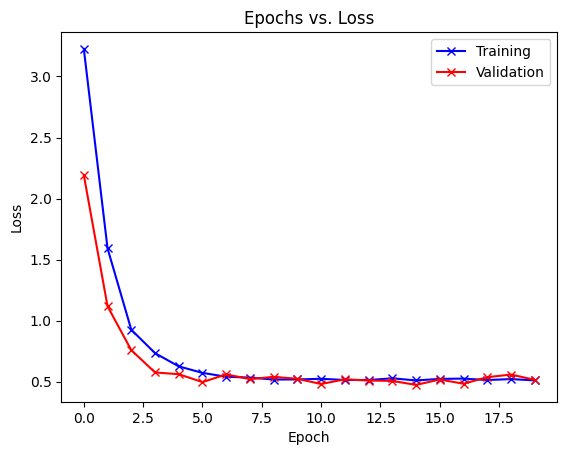

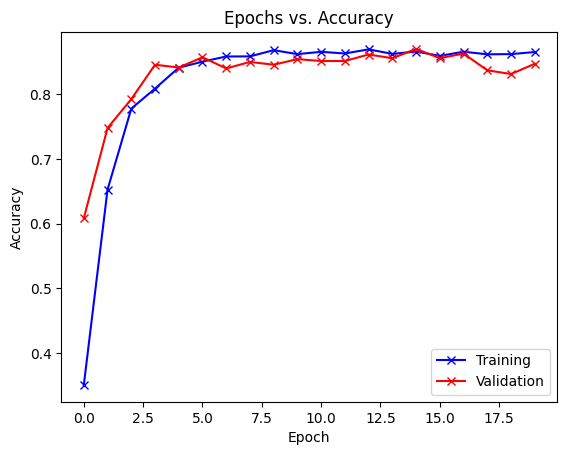

Files already downloaded and verified

Test Loss: 15.6863
Test Accuracy: 0.0063


In [ ]:
# "Normalize" condition
transform = compose_tensor(A.Normalize())
run_experiment("resnet50", "caltech101", transform, n_epochs, "Normalize")

In [ ]:
# "RandPPP" condition
transform = compose_tensor(A.Lambda(random_PPP))
run_experiment("resnet50", "caltech101", transform, n_epochs, "randPPP")

## Caltech101-ResneXt50 Experiments


Gauss condition, resnext50 model, caltech101 dataset


131740031it [00:02, 46239570.84it/s]


Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


14028800it [00:00, 23574573.87it/s]


Extracting data/caltech101/Annotations.tar to data/caltech101
Epoch 1/20
----------
train Loss: 3.1795 Acc: 0.3602
val Loss: 2.1982 Acc: 0.5914
Epoch 2/20
----------
train Loss: 1.5773 Acc: 0.6500
val Loss: 1.1872 Acc: 0.7108
Epoch 3/20
----------
train Loss: 0.9836 Acc: 0.7525
val Loss: 0.8272 Acc: 0.7986
Epoch 4/20
----------
train Loss: 0.7921 Acc: 0.7879
val Loss: 0.6539 Acc: 0.8230
Epoch 5/20
----------
train Loss: 0.6677 Acc: 0.8213
val Loss: 0.6793 Acc: 0.8187
Epoch 6/20
----------
train Loss: 0.5916 Acc: 0.8397
val Loss: 0.6368 Acc: 0.8360
Epoch 7/20
----------
train Loss: 0.5833 Acc: 0.8409
val Loss: 0.6507 Acc: 0.8273
Epoch 8/20
----------
train Loss: 0.5809 Acc: 0.8413
val Loss: 0.6287 Acc: 0.8230
Epoch 9/20
----------
train Loss: 0.5448 Acc: 0.8565
val Loss: 0.5420 Acc: 0.8489
Epoch 10/20
----------
train Loss: 0.5831 Acc: 0.8441
val Loss: 0.6299 Acc: 0.8417
Epoch 11/20
----------
train Loss: 0.5558 Acc: 0.8493
val Loss: 0.6458 Acc: 0.8331
Epoch 12/20
----------
train Loss:

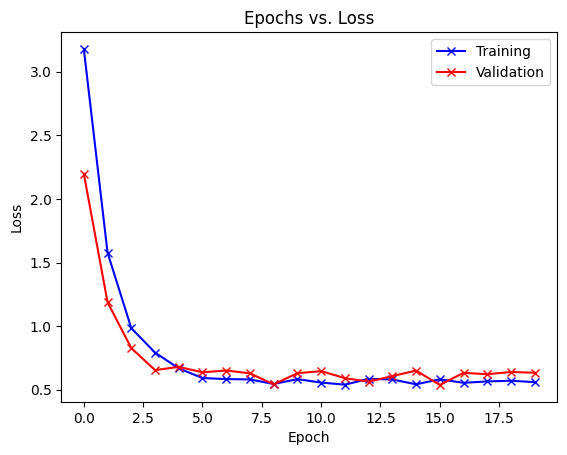

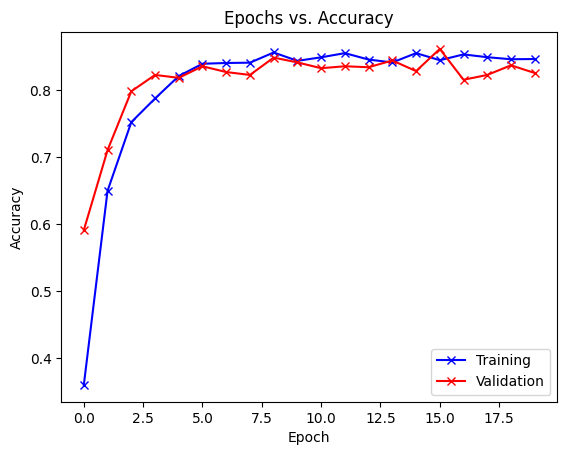

Files already downloaded and verified

Test Loss: 1.9575
Test Accuracy: 0.5340


In [ ]:
# "Gauss" condition
transform = compose_tensor(A.GaussNoise())
run_experiment("resnext50", "caltech101", transform, n_epochs, "Gauss")

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(



Brightness condition, resnext50 model, caltech101 dataset


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 98.8MB/s]
131740031it [00:02, 52346521.73it/s]


Extracting data/caltech101/101_ObjectCategories.tar.gz to data/caltech101


14028800it [00:00, 275491146.21it/s]


Extracting data/caltech101/Annotations.tar to data/caltech101
Epoch 1/20
----------
train Loss: 3.1520 Acc: 0.3791
val Loss: 2.2019 Acc: 0.5914
Epoch 2/20
----------
train Loss: 1.5842 Acc: 0.6537
val Loss: 1.0354 Acc: 0.7568
Epoch 3/20
----------
train Loss: 0.9809 Acc: 0.7512
val Loss: 0.8467 Acc: 0.7957
Epoch 4/20
----------
train Loss: 0.7999 Acc: 0.7880
val Loss: 0.7469 Acc: 0.7971
Epoch 5/20
----------
train Loss: 0.6600 Acc: 0.8216
val Loss: 0.5485 Acc: 0.8647
Epoch 6/20
----------
train Loss: 0.6107 Acc: 0.8377
val Loss: 0.5723 Acc: 0.8460
Epoch 7/20
----------
train Loss: 0.5866 Acc: 0.8447
val Loss: 0.6311 Acc: 0.8532
Epoch 8/20
----------
train Loss: 0.5917 Acc: 0.8410
val Loss: 0.6013 Acc: 0.8417
Epoch 9/20
----------
train Loss: 0.5516 Acc: 0.8530
val Loss: 0.5500 Acc: 0.8388
Epoch 10/20
----------
train Loss: 0.5792 Acc: 0.8439
val Loss: 0.5836 Acc: 0.8374
Epoch 11/20
----------
train Loss: 0.5678 Acc: 0.8469
val Loss: 0.6078 Acc: 0.8388
Epoch 12/20
----------
train Loss:

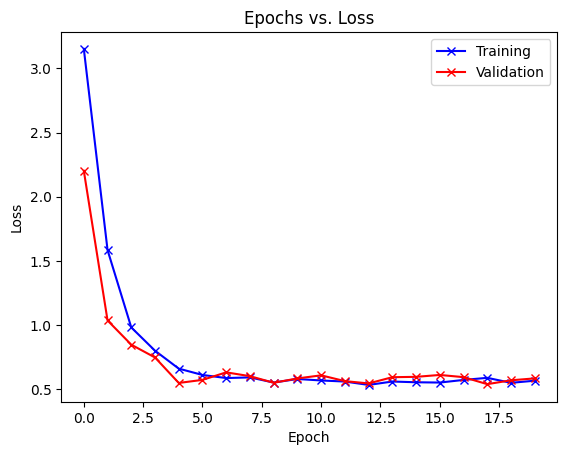

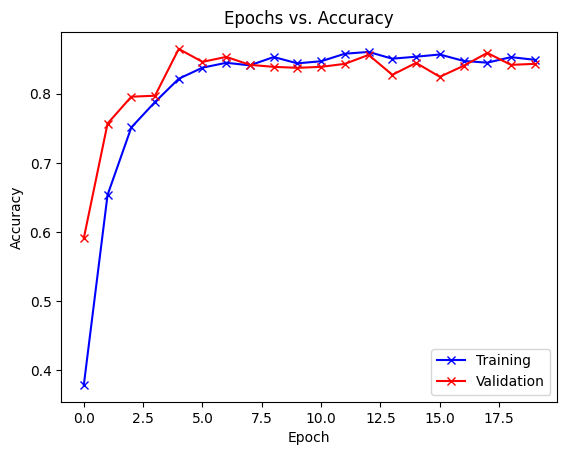

Files already downloaded and verified

Test Loss: 1.7128
Test Accuracy: 0.5835


In [12]:
# "Brightness" condition
transform = compose_tensor(A.RandomBrightness())
run_experiment("resnext50", "caltech101", transform, n_epochs, "Brightness")


Contrast condition, resnext50 model, caltech101 dataset


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2131 Acc: 0.3594
val Loss: 2.3201 Acc: 0.6216
Epoch 2/20
----------
train Loss: 1.6058 Acc: 0.6516
val Loss: 1.3708 Acc: 0.7540
Epoch 3/20
----------
train Loss: 0.9543 Acc: 0.7666
val Loss: 0.8015 Acc: 0.8000
Epoch 4/20
----------
train Loss: 0.7566 Acc: 0.8040
val Loss: 0.6875 Acc: 0.8288
Epoch 5/20
----------
train Loss: 0.6572 Acc: 0.8234
val Loss: 1.3875 Acc: 0.8129
Epoch 6/20
----------
train Loss: 0.5940 Acc: 0.8378
val Loss: 1.0537 Acc: 0.8288
Epoch 7/20
----------
train Loss: 0.5750 Acc: 0.8492
val Loss: 1.4373 Acc: 0.8144
Epoch 8/20
----------
train Loss: 0.5735 Acc: 0.8463
val Loss: 1.1101 Acc: 0.8403
Epoch 9/20
----------
train Loss: 0.5702 Acc: 0.8490
val Loss: 1.1238 Acc: 0.8331
Epoch 10/20
----------
train Loss: 0.5696 Acc: 0.8474
val Loss: 0.6108 Acc: 0.8504
Epoch 11/20
----------
train Loss: 0.5378 Acc: 0.8581
val Loss: 0.5391 Acc: 0.8460
Epoch 12/20
----------
train Loss: 0.5465 Acc: 0.8573
val 

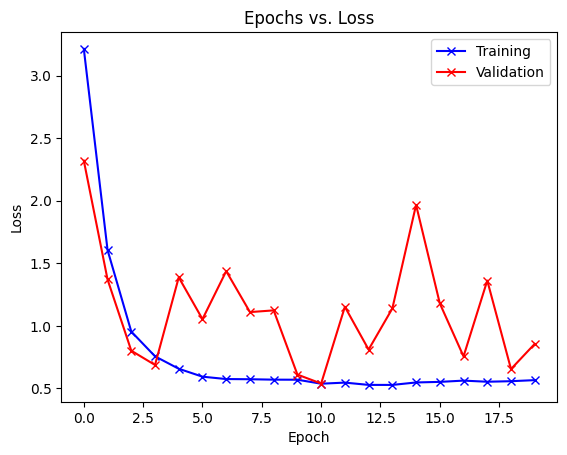

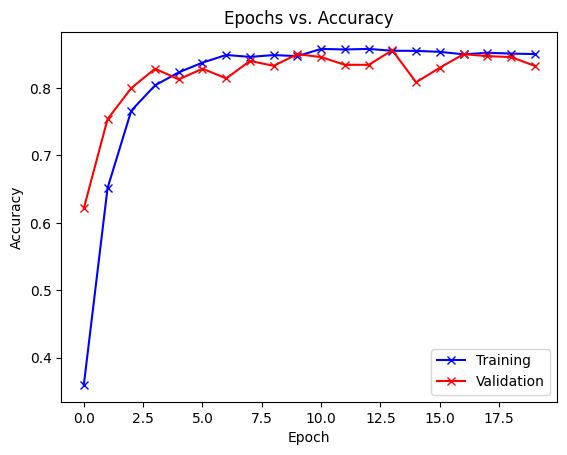

Files already downloaded and verified

Test Loss: 2.7888
Test Accuracy: 0.5524


In [13]:
# "Contrast" condition
transform = compose_tensor(A.RandomContrast())
run_experiment("resnext50", "caltech101", transform, n_epochs, "Contrast")


BrightnessContrast condition, resnext50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2088 Acc: 0.3617
val Loss: 2.4390 Acc: 0.5770
Epoch 2/20
----------
train Loss: 1.5927 Acc: 0.6636
val Loss: 1.2265 Acc: 0.7237
Epoch 3/20
----------
train Loss: 0.9698 Acc: 0.7610
val Loss: 0.8260 Acc: 0.8043
Epoch 4/20
----------
train Loss: 0.7869 Acc: 0.8000
val Loss: 0.7123 Acc: 0.8000
Epoch 5/20
----------
train Loss: 0.6671 Acc: 0.8221
val Loss: 0.5893 Acc: 0.8460
Epoch 6/20
----------
train Loss: 0.5996 Acc: 0.8378
val Loss: 0.8475 Acc: 0.7957
Epoch 7/20
----------
train Loss: 0.5755 Acc: 0.8482
val Loss: 0.6621 Acc: 0.8259
Epoch 8/20
----------
train Loss: 0.5731 Acc: 0.8527
val Loss: 0.7614 Acc: 0.8201
Epoch 9/20
----------
train Loss: 0.5825 Acc: 0.8498
val Loss: 0.5800 Acc: 0.8518
Epoch 10/20
----------
train Loss: 0.5505 Acc: 0.8549
val Loss: 0.5776 Acc: 0.8504
Epoch 11/20
----------
train Loss: 0.5794 Acc: 0.8455
val Loss: 0.5801 Acc

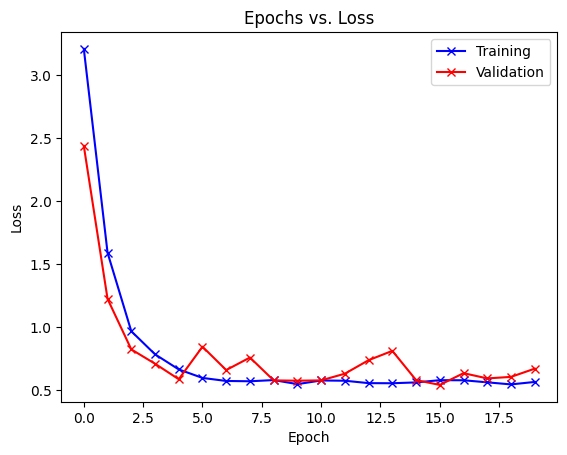

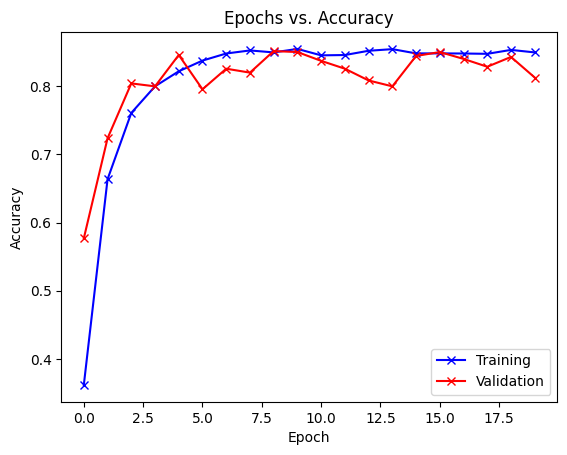

Files already downloaded and verified

Test Loss: 1.2968
Test Accuracy: 0.6694


In [14]:
# "BrightnessContrast" condition
transform = compose_tensor(A.RandomBrightnessContrast())
run_experiment("resnext50", "caltech101", transform, n_epochs, "BrightnessContrast")


Control condition, resnext50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.2081 Acc: 0.3702
val Loss: 2.3440 Acc: 0.5727
Epoch 2/20
----------
train Loss: 1.5872 Acc: 0.6567
val Loss: 1.2519 Acc: 0.7295
Epoch 3/20
----------
train Loss: 0.9684 Acc: 0.7622
val Loss: 1.1616 Acc: 0.7655
Epoch 4/20
----------
train Loss: 0.7657 Acc: 0.8029
val Loss: 0.8319 Acc: 0.7986
Epoch 5/20
----------
train Loss: 0.6465 Acc: 0.8279
val Loss: 0.6952 Acc: 0.8288
Epoch 6/20
----------
train Loss: 0.5966 Acc: 0.8429
val Loss: 0.6870 Acc: 0.8317
Epoch 7/20
----------
train Loss: 0.5589 Acc: 0.8489
val Loss: 0.7196 Acc: 0.8345
Epoch 8/20
----------
train Loss: 0.5668 Acc: 0.8533
val Loss: 1.1028 Acc: 0.8216
Epoch 9/20
----------
train Loss: 0.5378 Acc: 0.8519
val Loss: 1.4032 Acc: 0.8129
Epoch 10/20
----------
train Loss: 0.5417 Acc: 0.8545
val Loss: 0.8117 Acc: 0.8129
Epoch 11/20
----------
train Loss: 0.5349 Acc: 0.8557
val Loss: 0.9182 Acc: 0.8403
Ep

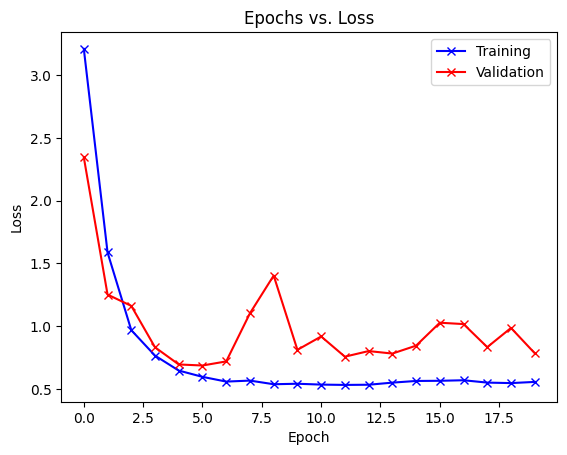

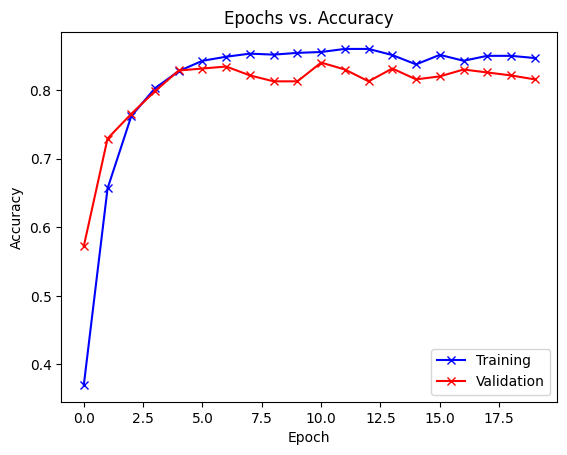

Files already downloaded and verified

Test Loss: 1.7627
Test Accuracy: 0.5732


In [15]:
# "Control" condition
run_experiment("resnext50", "caltech101", ToTensorV2(), n_epochs, "Control")


Normalize condition, resnext50 model, caltech101 dataset
Files already downloaded and verified
Epoch 1/20
----------
train Loss: 3.1754 Acc: 0.3639
val Loss: 2.2041 Acc: 0.6101
Epoch 2/20
----------
train Loss: 1.5662 Acc: 0.6612
val Loss: 1.2535 Acc: 0.7453
Epoch 3/20
----------
train Loss: 0.9767 Acc: 0.7608
val Loss: 1.4740 Acc: 0.7899
Epoch 4/20
----------
train Loss: 0.7728 Acc: 0.7944
val Loss: 0.7924 Acc: 0.8158
Epoch 5/20
----------
train Loss: 0.6494 Acc: 0.8256
val Loss: 0.8255 Acc: 0.8331
Epoch 6/20
----------
train Loss: 0.5655 Acc: 0.8479
val Loss: 1.2661 Acc: 0.8245
Epoch 7/20
----------
train Loss: 0.5762 Acc: 0.8466
val Loss: 0.6937 Acc: 0.8302
Epoch 8/20
----------
train Loss: 0.5519 Acc: 0.8529
val Loss: 0.6328 Acc: 0.8504
Epoch 9/20
----------
train Loss: 0.5729 Acc: 0.8495
val Loss: 0.9980 Acc: 0.8245
Epoch 10/20
----------
train Loss: 0.5593 Acc: 0.8500
val Loss: 0.7373 Acc: 0.8576
Epoch 11/20
----------
train Loss: 0.5446 Acc: 0.8533
val Loss: 0.6498 Acc: 0.8317


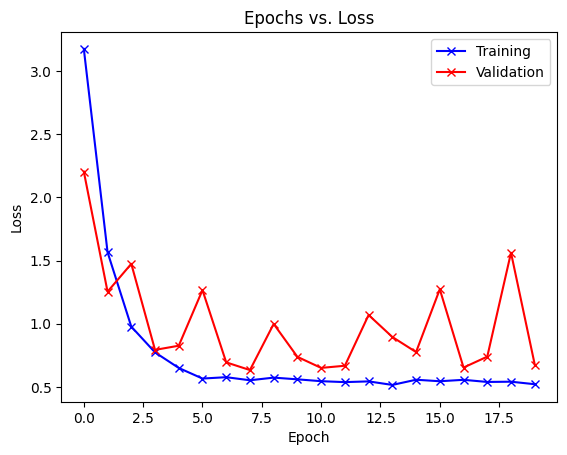

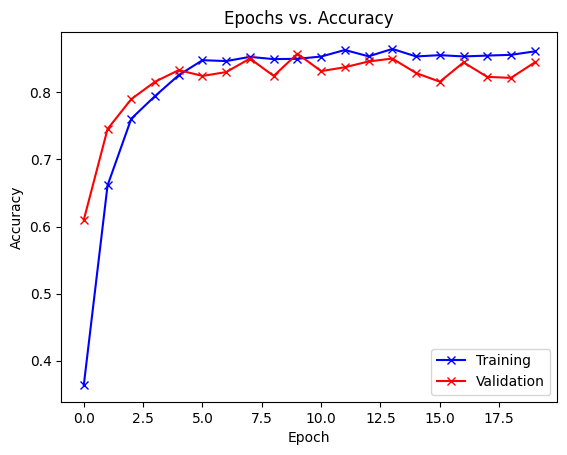

Files already downloaded and verified

Test Loss: 5095.5123
Test Accuracy: 0.0035


In [16]:
# "Normalize" condition
transform = compose_tensor(A.Normalize())
run_experiment("resnext50", "caltech101", transform, n_epochs, "Normalize")

In [ ]:
# "RandPPP" condition
transform = compose_tensor(A.Lambda(random_PPP))
run_experiment("resnext50", "caltech101", transform, n_epochs, "randPPP")